In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('drought_training_Yeo_Johnson_transform.xlsx')

training_df.head()

,339,341,342,344,345,346,348,349,351,352,...,2499,2501,2503,2505,2507,2509,2511,2514,2516,Water Potential (Mpa)_YJ_transform
0,0.1481,0.1818,0.1748,0.1486,0.1045,0.0782,0.0904,0.0830,0.1101,0.1168,...,0.0332,0.0347,0.0323,0.0308,0.0360,0.0346,0.0320,0.0328,0.0344,-0.081621
1,0.1422,0.1360,0.1384,0.1283,0.1103,0.0967,0.1014,0.1040,0.0934,0.0819,...,0.0560,0.0589,0.0560,0.0551,0.0563,0.0554,0.0533,0.0547,0.0528,-0.127508
2,0.0978,0.0920,0.1038,0.0981,0.0793,0.0613,0.0477,0.0520,0.0545,0.0698,...,0.0280,0.0252,0.0269,0.0275,0.0293,0.0311,0.0284,0.0279,0.0294,-0.112437
3,0.1422,0.1360,0.1538,0.1283,0.1241,0.1161,0.1074,0.0876,0.0831,0.0722,...,0.0456,0.0473,0.0484,0.0452,0.0428,0.0450,0.0486,0.0425,0.0479,-0.139553
4,0.1333,0.1280,0.1307,0.0981,0.1034,0.0838,0.0776,0.0767,0.0779,0.0722,...,0.0373,0.0347,0.0323,0.0330,0.0360,0.0369,0.0344,0.0340,0.0405,-0.239931


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)_YJ_transform'])
y = training_df['Water Potential (Mpa)_YJ_transform']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 00:24:51,621] A new study created in memory with name: no-name-ef3227bc-f029-46c8-bb6a-fb8a7cbfa8e9
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:52,640] Trial 0 finished with value: 0.05230903976787575 and parameters: {'n_components': 939, 'max_iter': 518}. Best is trial 0 with value: 0.05230903976787575.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:52,706] Trial 1 finished with value: 0.05230903976787548 and parameters: {'n_components': 192, 'max_iter': 624}. Best is trial 1 with value: 0.05230903976787548.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWar

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:55,875] Trial 24 finished with value: 0.05230903976787548 and parameters: {'n_components': 290, 'max_iter': 195}. Best is trial 19 with value: 0.028159532836414713.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:55,929] Trial 25 finished with value: 0.052309039767875064 and parameters: {'n_components': 119, 'max_iter': 445}. Best is trial 19 with value: 0.028159532836414713.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I

/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:59,241] Trial 48 finished with value: 0.05230903976787596 and parameters: {'n_components': 794, 'max_iter': 455}. Best is trial 19 with value: 0.028159532836414713.
[I 2024-02-26 00:24:59,271] Trial 49 finished with value: 0.04057422529779163 and parameters: {'n_components': 5, 'max_iter': 344}. Best is trial 19 with value: 0.028159532836414713.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:24:59,316] Trial 50 finished with value: 0.05230903976787542 and parameters: {'n_components': 136, 'max_iter': 509}. Best is trial 19 with value: 0.028159532836414713.
[I 2024-02-26 00:24:59,342] T

[I 2024-02-26 00:25:00,351] Trial 75 finished with value: 0.028159532836414713 and parameters: {'n_components': 2, 'max_iter': 424}. Best is trial 19 with value: 0.028159532836414713.
[I 2024-02-26 00:25:00,391] Trial 76 finished with value: 0.05250783109667272 and parameters: {'n_components': 32, 'max_iter': 672}. Best is trial 19 with value: 0.028159532836414713.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:25:00,435] Trial 77 finished with value: 0.052309039767875064 and parameters: {'n_components': 63, 'max_iter': 466}. Best is trial 19 with value: 0.028159532836414713.
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 40
  warnings.warn(f"Y residual is constant at iteration {k}")
[I 2024-02-26 00:25:00,487] T

Number of finished trials:  100
Best trial:
  Value: 0.028159532836414713
  Params: 
    n_components: 2
    max_iter: 426
Mean Squared Error: 0.028159532836414713
Root Mean Squared Error: 0.16780802375457116
R-Squared value: 0.24834082821565862


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
527: 0.000613352071336088
526: 0.0006132214577729463
528: 0.0006112095596735789


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 00:25:01,991] A new study created in memory with name: no-name-07085563-a1d5-4d97-af2d-6bc409e22e65
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:02,013] Trial 0 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 0.04660971400397398.
/var/folders/3h/63

[I 2024-02-26 00:25:02,149] Trial 9 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.47841987416050147, 'l1_ratio': 0.17893744751587604, 'max_iter': 913}. Best is trial 7 with value: 0.03576458668021166.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:02,303] Trial 10 finished with value: 0.034951010356966634 and parameters: {'alpha': 0.27682391622961355, 'l1_

[I 2024-02-26 00:25:02,794] Trial 18 finished with value: 0.04354075649052646 and parameters: {'alpha': 0.16169994925127928, 'l1_ratio': 0.3554406782753273, 'max_iter': 303}. Best is trial 10 with value: 0.034951010356966634.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Obj

[I 2024-02-26 00:25:03,510] Trial 27 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.35142778797356844, 'l1_ratio': 0.35190047355730303, 'max_iter': 500}. Best is trial 21 with value: 0.03482340131724394.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:03,550] Trial 28 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.4484565801097833, 'l1_

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:03,837] Trial 36 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.40381767966626764, 'l1_ratio': 0.7029435404175004, 'max_iter': 165}. Best is trial 21 with value: 0.03482340131724394.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been depreca

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:04,184] Trial 45 finished with value: 0.03486667459339811 and parameters: {'alpha': 0.4877466080101135, 'l1_ratio': 0.042378643639438954, 'max_iter': 159}. Best is trial 44 with value: 0.034565534731354104.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been depre

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:04,661] Trial 55 finished with value: 0.04660971400397398 and parameters: {'alpha': 0.7083072787024776, 'l1_ratio': 0.10135381189193948, 'max_iter': 372}. Best is trial 46 with value: 0.03422413276984233.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been depreca

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:05,052] Trial 64 finished with value: 0.042638425111688735 and parameters: {'alpha': 0.4403966613148371, 'l1_ratio': 0.12073969514140631, 'max_iter': 209}. Best is trial 46 with value: 0.03422413276984233.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprec

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:05,507] Trial 73 finished with value: 0.034117127070407496 and parameters: {'alpha': 0.6747696484671708, 'l1_ratio': 0.010558397975804214, 'max_iter': 395}. Best is trial 73 with value: 0.034117127070407496.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been depr

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:05,875] Trial 82 finished with value: 0.03430104772510644 and parameters: {'alpha': 0.6383955047154191, 'l1_ratio': 0.021226445017985297, 'max_iter': 312}. Best is trial 73 with value: 0.034117127070407496.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been depre

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-02-26 00:25:06,364] Trial 92 finished with value: 0.03406035058471191 and parameters: {'alpha': 0.8109585847414972, 'l1_ratio': 0.01601794532017399, 'max_iter': 463}. Best is trial 92 with value: 0.03406035058471191.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/3317287144.py:5: FutureWarning: suggest_uniform has been depreca

Number of finished trials:  100
Best trial:
  Value: 0.03403122096740249
  Params: 
    alpha: 0.8066911437116938
    l1_ratio: 0.018593563349899474
    max_iter: 550
Mean Squared Error: 0.03403122096740249
Root Mean Squared Error: 0.18447552945418666
R-Squared value: 0.09160853215260523


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
339: -0.007114607429910814
1891: -0.005782918192316144
1887: -0.005590811049962751


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 00:25:06,820] A new study created in memory with name: no-name-4c671b97-5d67-4cf9-a0b1-d8995152dbd6
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:06,872] Trial 0 finished with value: 0.2677280685190128 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 0.2677280685190128.
/var/fold

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:07,025] Trial 10 finished with value: 0.033493214428545554 and parameters: {'alpha': 0.003915949640957761, 'gamma': 8.218006795527931e-06, 'kernel': 'rbf'}. Best is trial 10 with value: 0.033493214428545554.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform 

[I 2024-02-26 00:25:07,344] Trial 19 finished with value: 0.2345884483781516 and parameters: {'alpha': 0.26815016060719377, 'gamma': 0.021529909135048243, 'kernel': 'rbf'}. Best is trial 11 with value: 0.03263390806458422.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:07,381] Trial 20 finished with value: 0.04385311529013481 and parameters: {'alpha': 0.08943746128

[I 2024-02-26 00:25:07,665] Trial 29 finished with value: 0.26772806851903724 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.5846304792512553, 'kernel': 'rbf'}. Best is trial 11 with value: 0.03263390806458422.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:07,693] Trial 30 finished with value: 0.26753646946581333 and parameters: {'alpha': 0.3928432009924

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:08,070] Trial 39 finished with value: 0.26772806851903724 and parameters: {'alpha': 0.05588118814102934, 'gamma': 16.4293947043477, 'kernel': 'rbf'}. Best is trial 11 with value: 0.03263390806458422.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has b

[I 2024-02-26 00:25:08,452] Trial 48 finished with value: 0.03968808495014328 and parameters: {'alpha': 0.1415707860144331, 'gamma': 0.0005142102856291891, 'kernel': 'rbf'}. Best is trial 11 with value: 0.03263390806458422.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:08,484] Trial 49 finished with value: 0.04015840827208368 and parameters: {'alpha': 0.0047622526

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:08,768] Trial 58 finished with value: 3.812351020266858 and parameters: {'alpha': 0.04211884094080465, 'gamma': 0.00020276016605036388, 'kernel': 'linear'}. Best is trial 11 with value: 0.03263390806458422.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform h

[I 2024-02-26 00:25:09,081] Trial 67 finished with value: 0.061761526950932094 and parameters: {'alpha': 0.1635495291457353, 'gamma': 0.001504263987112562, 'kernel': 'rbf'}. Best is trial 62 with value: 0.03259060687571304.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:09,136] Trial 68 finished with value: 0.04599681644426616 and parameters: {'alpha': 0.6519976785

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:09,486] Trial 77 finished with value: 0.03820590409300325 and parameters: {'alpha': 0.09881944456329063, 'gamma': 7.387169949391718e-06, 'kernel': 'rbf'}. Best is trial 62 with value: 0.03259060687571304.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has

[I 2024-02-26 00:25:09,901] Trial 86 finished with value: 3.561434456506949 and parameters: {'alpha': 0.09843841501628395, 'gamma': 0.11545693049103045, 'kernel': 'linear'}. Best is trial 62 with value: 0.03259060687571304.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:09,931] Trial 87 finished with value: 0.03815317173793235 and parameters: {'alpha': 0.1349208721

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-02-26 00:25:10,266] Trial 96 finished with value: 0.04125143516221489 and parameters: {'alpha': 0.05362738834267895, 'gamma': 1.5371781869189718e-06, 'kernel': 'rbf'}. Best is trial 88 with value: 0.031887751367798194.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/295769073.py:4: FutureWarning: suggest_uniform h

Number of finished trials:  100
Best trial:
  Value: 0.031887751367798194
  Params: 
    alpha: 0.002293429637209299
    gamma: 1.7297312683208216e-06
    kernel: rbf
Mean Squared Error: 0.031887751367798194
Root Mean Squared Error: 0.1785714181155489
R-Squared value: 0.14882391968559727


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
396: 19526.10248025576
358: 15086.384774678274
344: 14730.040733434329


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 3


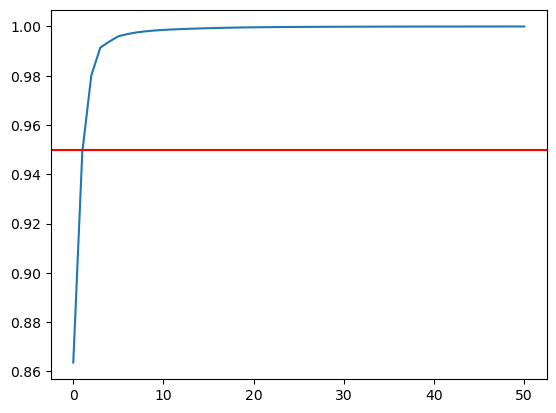

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 0.02931726226345442
Root Mean Squared Error: 0.17122284387153025
R-Squared value: 0.21743768975330102


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
516: 0.007582500860643115
514: 0.007567127839993856
517: 0.007528902309532986


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 00:25:10,825] A new study created in memory with name: no-name-13c20c76-ef1d-4f66-9765-f630e84492b8
[I 2024-02-26 00:25:11,668] Trial 0 finished with value: 0.04468572428277621 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.04468572428277621.
[I 2024-02-26 00:25:12,162] Trial 1 finished with value: 0.04227761324104585 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.04227761324104585.
[I 2024-02-26 00:25:12,501] Trial 2 finished with value: 0.04179701774026413 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.04179701774026413.
[I 2024-02-26 00:25:13,104] Trial 3 finished with value: 0.04050901909514636 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 wit

[I 2024-02-26 00:25:33,715] Trial 36 finished with value: 0.045328272880953854 and parameters: {'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:25:34,484] Trial 37 finished with value: 0.04336613627648612 and parameters: {'n_estimators': 140, 'max_depth': 19, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:25:35,193] Trial 38 finished with value: 0.04214915294616297 and parameters: {'n_estimators': 106, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:25:36,348] Trial 39 finished with value: 0.04249310255757042 and parameters: {'n_estimators': 97, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:25:36,898] Trial 40 finished with value: 0.0421234656923247 

[I 2024-02-26 00:26:00,311] Trial 72 finished with value: 0.04063824002570447 and parameters: {'n_estimators': 63, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:26:00,776] Trial 73 finished with value: 0.038926341071708254 and parameters: {'n_estimators': 70, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 3}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:26:01,411] Trial 74 finished with value: 0.043731337300564416 and parameters: {'n_estimators': 78, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:26:01,830] Trial 75 finished with value: 0.04023679806453785 and parameters: {'n_estimators': 71, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 4}. Best is trial 12 with value: 0.03707307040615921.
[I 2024-02-26 00:26:02,215] Trial 76 finished with value: 0.044078310339825

Best trial:
  Value: 0.0350521716402282
  Params: 
    n_estimators: 50
    max_depth: 16
    min_samples_split: 9
    min_samples_leaf: 4
Mean Squared Error: 0.04229615815747038
Root Mean Squared Error: 0.20566029796115334
R-Squared value: -0.12900648583172702


## <font color = darkblue> Variable Importance Information of RF

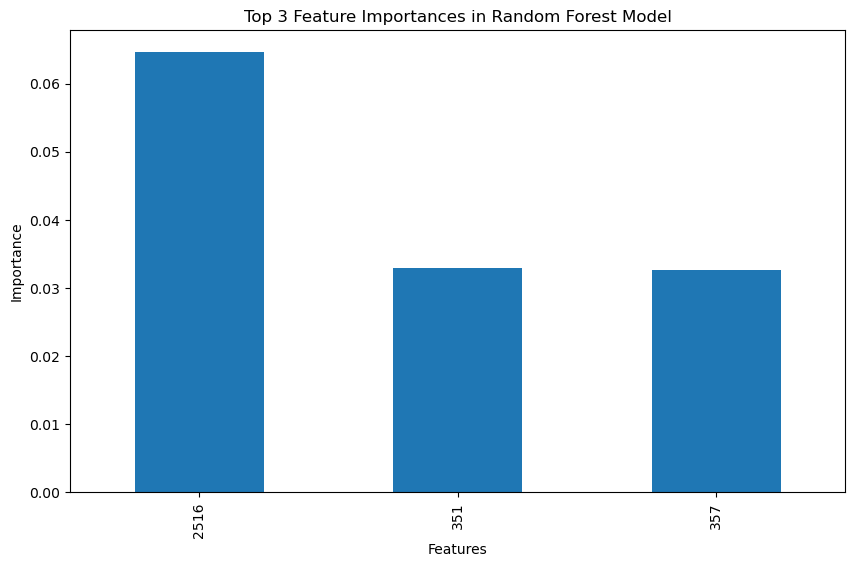

In [15]:
# Extract feature importances
feature_importances = best_rf_model.feature_importances_

# Create a series with feature names and their importance
features = pd.Series(feature_importances, index = X.columns)

# Sort the features by importance
features = features.sort_values(ascending=False)

# Select the top 3 features
top_3_features = features[:3]

# Plot the top 3 feature importances
plt.figure(figsize=(10, 6))
top_3_features.plot(kind='bar')
plt.title('Top 3 Feature Importances in Random Forest Model')
plt.ylabel('Importance')
plt.xlabel('Features')

plt.show()

## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-02-26 00:26:16,579] A new study created in memory with name: no-name-4b61cf33-4ea3-415c-a0ce-1aaef31b7647
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:26:20,332] Trial 0 finished with value: 0.08087229701768124 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 0.08087229701768124.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.su

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:26:52,730] Trial 14 finished with value: 0.06400856151650013 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.07849341548804481}. Best is trial 10 with value: 0.051952476079887754.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:26:54,202] Trial 1

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:27:13,235] Trial 28 finished with value: 0.05582895540897057 and parameters: {'n_estimators': 58, 'max_depth': 3, 'learning_rate': 0.01460674438045179}. Best is trial 21 with value: 0.04789948908812043.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:27:17,192] Trial 29

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:27:41,621] Trial 42 finished with value: 0.05194324584088029 and parameters: {'n_estimators': 96, 'max_depth': 3, 'learning_rate': 0.05663163346699791}. Best is trial 21 with value: 0.04789948908812043.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:27:43,336] Trial 43

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:09,649] Trial 56 finished with value: 0.06400665815813401 and parameters: {'n_estimators': 94, 'max_depth': 4, 'learning_rate': 0.0516259065901211}. Best is trial 21 with value: 0.04789948908812043.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:11,403] Trial 57 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:30,918] Trial 70 finished with value: 0.06663064452934728 and parameters: {'n_estimators': 71, 'max_depth': 4, 'learning_rate': 0.03595871706138187}. Best is trial 21 with value: 0.04789948908812043.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:32,160] Trial 71

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:52,436] Trial 84 finished with value: 0.05151296527420477 and parameters: {'n_estimators': 81, 'max_depth': 3, 'learning_rate': 0.05723997846331794}. Best is trial 81 with value: 0.04766053546898417.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:28:54,215] Trial 85

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:29:12,646] Trial 98 finished with value: 0.05127064078250298 and parameters: {'n_estimators': 105, 'max_depth': 3, 'learning_rate': 0.040445486523946084}. Best is trial 81 with value: 0.04766053546898417.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-02-26 00:29:15,219] Trial 

Best trial:
  Value: 0.04766053546898417
  Params: 
    n_estimators: 88
    max_depth: 3
    learning_rate: 0.05521571225001499
Mean Squared Error: 0.05043606793401145
Root Mean Squared Error: 0.22457975851356562
R-Squared value: -0.3462841614443717


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
1898: 0.09682107655587702
2509: 0.045764230160095315
362: 0.04345854576355002


## <font color = green> XGBoost

In [18]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-02-26 00:29:16,635] A new study created in memory with name: no-name-447e673f-2fb5-45c2-b479-c7add515dd07
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-02-26 00:29:19,958] Trial 6 finished with value: 0.04567854265652432 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 4 with value: 0.03715750578023297.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:29:26,245] Trial 19 finished with value: 0.03606093465278212 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.03829075620127187, 'min_child_weight': 3, 'subsample': 0.5913850174102684, 'colsample_bytree': 0.6150182457831486}. Best is trial 15 with value: 0.034907251142913966.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/6

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:29:32,405] Trial 32 finished with value: 0.03866243435961913 and parameters: {'n_estimators': 91, 'max_depth': 5, 'learning_rate': 0.048487931080108675, 'min_child_weight': 3, 'subsample': 0.6276872274820213, 'colsample_bytree': 0.6510426746080016}. Best is trial 15 with value: 0.034907251142913966.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/6

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:29:38,558] Trial 45 finished with value: 0.04017811688714595 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.06742317442068312, 'min_child_weight': 3, 'subsample': 0.5422264674991557, 'colsample_bytree': 0.6050109704479224}. Best is trial 15 with value: 0.034907251142913966.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/6

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:29:50,423] Trial 58 finished with value: 0.043080888458172366 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.03419217475254786, 'min_child_weight': 4, 'subsample': 0.9093902301024989, 'colsample_bytree': 0.5447115726687601}. Best is trial 47 with value: 0.03243543601807197.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:29:58,030] Trial 71 finished with value: 0.03901844801310632 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.048087051922587665, 'min_child_weight': 3, 'subsample': 0.599596547530295, 'colsample_bytree': 0.6249744973464202}. Best is trial 47 with value: 0.03243543601807197.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:30:04,386] Trial 84 finished with value: 0.0343751558967184 and parameters: {'n_estimators': 102, 'max_depth': 9, 'learning_rate': 0.0526560319686169, 'min_child_weight': 5, 'subsample': 0.7136449591856326, 'colsample_bytree': 0.9685211763752449}. Best is trial 78 with value: 0.031071527652250498.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-02-26 00:30:09,368] Trial 97 finished with value: 0.04205546989376202 and parameters: {'n_estimators': 109, 'max_depth': 7, 'learning_rate': 0.0646036126472757, 'min_child_weight': 8, 'subsample': 0.6803780656985204, 'colsample_bytree': 0.9919654979662704}. Best is trial 78 with value: 0.031071527652250498.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_47356/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/63

Best trial:
  Value: 0.031071527652250498
  Params: 
    n_estimators: 116
    max_depth: 9
    learning_rate: 0.05707988470302637
    min_child_weight: 5
    subsample: 0.7143120769185501
    colsample_bytree: 0.8071689680514423
Mean Squared Error: 0.031071527652250498
Root Mean Squared Error: 0.17627117646470308
R-Squared value: 0.17061128546270055


In [19]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
498: 0.039725858718156815
573: 0.03776249662041664
1898: 0.03173959255218506
